In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from ligo.em_bright import em_bright
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse
import configparser
from scipy.stats import linregress
import random

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
print("Loading CSV data...")
#file_PE_events = 'PE_events_1360608000_1364064000.csv'
file_crossmatch = 'MDC11_crossmatch.csv'
#PE_events_df = pd.read_csv(file_PE_events)
crossmatch_df = pd.read_csv(file_crossmatch)
print("CSV data loaded.")

Loading CSV data...
CSV data loaded.


In [3]:
crossmatch_df.head()

,event,mass1_source_inj,mass2_source_inj,spin1z_inj,spin2z_inj,Mc_source_inj,z_inj,distance_inj,inclination_inj,gpstime
0,S230224fj,66.277006,56.133233,0.077648,-0.121831,53.062318,0.643958,3973.558833,0.695495,NaN
1,S230224fl,1.643908,1.026671,-0.013350,-0.039123,1.124771,0.020121,90.968922,0.514122,NaN
2,S230224fn,1.364134,1.179050,-0.134013,-0.054188,1.103463,0.030353,138.264201,2.794457,NaN
3,S230224fp,1.674409,1.378832,-0.027307,-0.036907,1.321513,0.058050,269.717311,2.684058,NaN
4,S230224fr,66.517938,24.983228,0.092389,-0.061930,34.679040,0.381533,2127.184145,0.633195,NaN


In [4]:
len(crossmatch_df)

1397

In [5]:
# True injected values
true_values_df = crossmatch_df[['event', 'mass1_source_inj', 'mass2_source_inj', 'spin1z_inj', 'spin2z_inj']]

In [6]:
true_values_df

,event,mass1_source_inj,mass2_source_inj,spin1z_inj,spin2z_inj
0,S230224fj,66.277006,56.133233,0.077648,-0.121831
1,S230224fl,1.643908,1.026671,-0.013350,-0.039123
2,S230224fn,1.364134,1.179050,-0.134013,-0.054188
3,S230224fp,1.674409,1.378832,-0.027307,-0.036907
4,S230224fr,66.517938,24.983228,0.092389,-0.061930
...,...,...,...,...,...
1392,S230328fn,1.686084,1.137612,-0.181541,-0.058286
1393,S230328fp,1.827680,1.764188,-0.060399,0.339704
1394,S230328fx,61.308766,61.124651,0.121864,0.197849
1395,S230328gc,4.629664,2.035514,-0.110272,0.227168


In [7]:
'''
MAKE SURE CROSSMATCH EVENTS MATCH PE EVENTS. BECAUSE PE HAS 1429 AND CROSSMATCH HAS 1397. THEN FIND THE MATCHING POSTERIOR HDF5 FILE.

ALSO USE TRY AND EXCEPT TO LOG EVENT IF THEY DONT MATCH AND STILL PASSING THROUGH OR IF ONE EXISTS IN THE OTHER

OUR GOAL IS TO USE THE MATCHING EVENTS (OUTSIDE OF ROC CURVE (FAR)) FOR EM_BRIGHT FINDINGS AND MAKE REGRESSIVE PREDICTIONS ON IT

WHEN GETTING THE POSTERIOR DISTRIBUTION WE WANT TO USE FEATURES LIKE MEAN, MEDIAN, STD, KURTOSIS, AND SKEWNESS TO PREDICT WHAT ARE THE
INJECTED TRUE CROSSMATCH VALUES

THEN EVENTUALLY WE WILL USE THE FEATURED PARAMETERS TO REGRESS TO THE RECOVERED PARAMETERS AND/OR DIRECTLY GO FROM RECOVERED TO INJECTED

RECOVERED VALUES COME FROM THE MATCH FILTERING OF THE WAVE FUNCTIONS NOISE IN THE DATA. DUE TO NOISE IN THE DATA THE RECOVERED VALUE USUALLY 
IS SLIGHTLY OFF OF THE INJECTED TRUE VALUE.
'''
#/Users/eltonago/EM_bright/MDC11_alpha_data/home/elton/MDC11_Data_Events/MDC11_PE/1360608000_1364064000
# Base directory path
base_directory = "MDC11_PE/1360608000_1364064000"

# Extract the list of events from the CSV file
file_crossmatch = crossmatch_df['event'].tolist()
unmatched_events = set(file_crossmatch)

# Initialize lists to collect data
mass_1_source_list = []
mass_2_source_list = []
spin_1z_source_list = []
spin_2z_source_list = []
matched_events = []
# Initialize lists to track processing outcomes
successful_events = []  # Events with successfully collected data
error_events = []       # Events that caused errors
skipped_events = []     # Matched events with no valid .hdf5 files

# Iterate through all subdirectories in the base directory
for root, dirs, files in os.walk(base_directory):
    for directory in dirs:
        if directory in unmatched_events:
            print(f"Matching directory found: {directory}")
            directory_path = os.path.join(root, directory)
            unmatched_events.discard(directory)  # Remove matched directory from unmatched events
            matched_events.append(directory)
            
            try:
                collected = False
                # Iterate through all files in the matching directory
                for file in os.listdir(directory_path):
                    if file.endswith('.hdf5') and file.startswith('Bilby.fast_test'):
                        collected = True
                        file_path = os.path.join(directory_path, file)
                        print(f"Processing file: {file_path}")
                        
                        # Open and process the .hdf5 file
                        with h5py.File(file_path, "r") as f:
                            posterior_samples = f['posterior_samples']
                            
                            # Extract posterior parameters for the event
                            mass_1_source = np.array(posterior_samples['mass_1_source'])
                            mass_2_source = np.array(posterior_samples['mass_2_source'])
                            spin_1z_source = np.array(posterior_samples['spin_1z'])
                            spin_2z_source = np.array(posterior_samples['spin_2z'])
                            
                            # Append the event's parameters
                            mass_1_source_list.append(mass_1_source)
                            mass_2_source_list.append(mass_2_source)
                            spin_1z_source_list.append(spin_1z_source)
                            spin_2z_source_list.append(spin_2z_source)
                            
                            print(f"Loaded data from {file_path}")
                        break  # Exit loop after processing the first valid .hdf5 file

                if collected:
                    successful_events.append(directory)
                else:
                    skipped_events.append(directory)
                    
            except Exception as e:
                error_events.append(directory)
                print(f"Error processing {directory}: {e}")

# Print out any unmatched events
if unmatched_events:
    print("The following events from the CSV did not have matching directories:")
    for event in unmatched_events:
        print(event)
else:
    print("All events in the CSV matched a directory.")

# Convert lists to NumPy arrays
mass_1_source_array = np.array(mass_1_source_list, dtype=object)
mass_2_source_array = np.array(mass_2_source_list, dtype=object)
spin_1z_source_array = np.array(spin_1z_source_list, dtype=object)
spin_2z_source_array = np.array(spin_2z_source_list, dtype=object)

# Filter true values to only include matched events
matched_true_values_df = true_values_df[true_values_df['event'].isin(matched_events)]

# Extract y_values corresponding to the matched events
y_values = matched_true_values_df[['mass1_source_inj', 'mass2_source_inj', 'spin1z_inj', 'spin2z_inj']].values

# Print the number of events processed
print(f"Number of events collected: {len(mass_1_source_array)}")
print(f"Number of events in CSV: {len(file_crossmatch)}")
print(f"Number of matched events: {len(matched_true_values_df)}")
print(f"Number of successful events: {len(successful_events)}")
print(f"Number of events with errors: {len(error_events)}")
print(f"Number of skipped events (no valid .hdf5 files): {len(skipped_events)}")

Matching directory found: S230322ca
Processing file: MDC11_PE/1360608000_1364064000/S230322ca/Bilby.fast_test.posterior_samples.hdf5
Loaded data from MDC11_PE/1360608000_1364064000/S230322ca/Bilby.fast_test.posterior_samples.hdf5
Matching directory found: S230316hf
Processing file: MDC11_PE/1360608000_1364064000/S230316hf/Bilby.fast_test.posterior_samples.hdf5
Loaded data from MDC11_PE/1360608000_1364064000/S230316hf/Bilby.fast_test.posterior_samples.hdf5
Matching directory found: S230307fk
Matching directory found: S230305ei
Processing file: MDC11_PE/1360608000_1364064000/S230305ei/Bilby.fast_test.posterior_samples.hdf5
Loaded data from MDC11_PE/1360608000_1364064000/S230305ei/Bilby.fast_test.posterior_samples.hdf5
Matching directory found: S230305cp
Processing file: MDC11_PE/1360608000_1364064000/S230305cp/Bilby.fast_test.posterior_samples.hdf5
Loaded data from MDC11_PE/1360608000_1364064000/S230305cp/Bilby.fast_test.posterior_samples.hdf5
Matching directory found: S230224iq
Processi

In [8]:
len(matched_events)

1397

In [9]:
matched_true_values_df

,event,mass1_source_inj,mass2_source_inj,spin1z_inj,spin2z_inj
0,S230224fj,66.277006,56.133233,0.077648,-0.121831
1,S230224fl,1.643908,1.026671,-0.013350,-0.039123
2,S230224fn,1.364134,1.179050,-0.134013,-0.054188
3,S230224fp,1.674409,1.378832,-0.027307,-0.036907
4,S230224fr,66.517938,24.983228,0.092389,-0.061930
...,...,...,...,...,...
1392,S230328fn,1.686084,1.137612,-0.181541,-0.058286
1393,S230328fp,1.827680,1.764188,-0.060399,0.339704
1394,S230328fx,61.308766,61.124651,0.121864,0.197849
1395,S230328gc,4.629664,2.035514,-0.110272,0.227168


In [10]:
len(y_values)

1397

In [11]:
mass_1_source_array

array([array([14.65792971, 16.31567068, 14.52975834, ..., 16.96517992,
              17.18059229, 16.79162251])                              ,
       array([160.75940606, 134.33970009, 183.99557375, ..., 161.33397834,
              153.12119894, 161.61617766])                                ,
       array([ 7.95625355,  9.3041081 , 10.43407493, ...,  8.90290014,
              12.16581542,  9.12907686])                              ,
       ...,
       array([4.54674461, 4.51154349, 4.57559226, ..., 4.57124945, 4.56256389,
              4.57069892])                                                    ,
       array([2.97151994, 2.20050601, 2.04679445, ..., 2.30579267, 1.94791834,
              1.916253  ])                                                    ,
       array([227.09268827, 227.07695722, 227.09259555, ..., 227.09176781,
              227.08778173, 227.08534477])                                ],
      dtype=object)

In [12]:
len(mass_1_source_array)

1207

In [13]:
# Load true values
true_values_df = crossmatch_df[['event', 'mass1_source_inj', 'mass2_source_inj', 'spin1z_inj', 'spin2z_inj']]
y_values = true_values_df["mass1_source_inj"].values

In [14]:
true_values_df

,event,mass1_source_inj,mass2_source_inj,spin1z_inj,spin2z_inj
0,S230224fj,66.277006,56.133233,0.077648,-0.121831
1,S230224fl,1.643908,1.026671,-0.013350,-0.039123
2,S230224fn,1.364134,1.179050,-0.134013,-0.054188
3,S230224fp,1.674409,1.378832,-0.027307,-0.036907
4,S230224fr,66.517938,24.983228,0.092389,-0.061930
...,...,...,...,...,...
1392,S230328fn,1.686084,1.137612,-0.181541,-0.058286
1393,S230328fp,1.827680,1.764188,-0.060399,0.339704
1394,S230328fx,61.308766,61.124651,0.121864,0.197849
1395,S230328gc,4.629664,2.035514,-0.110272,0.227168


In [15]:
len(mass_1_source_array)

1207

In [16]:
#print("posterior df", posterior_df.head())
#print("length of", len(posterior_df["mass_1_source"]))

In [17]:
#posterior_df

In [18]:
# Convert dataframes to numpy arrays

#X = posterior_df["mass_1_source"]
#y = true_values_df["mass1_source_inj"][0]

# Split the data into training and testing sets
# No random state, random states produce the same prediction result, if we want a different prediction and more randomness we remove the random state.

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Generate a random seed if random_state is not provided
#if random_state is None:
#random_state = random.randint(0, 10000)

In [19]:
#X[0]

In [ ]:
#y

In [20]:
# Check the sizes of the arrays
print(f"Size of mass_1_source_array: {len(mass_1_source_array)}")
print(f"Size of y_values: {len(y_values)}")

# If the sizes are different, print a warning
if len(mass_1_source_array) != len(y_values):
    print("Warning: The size of mass_1_source_array and y_values do not match!")

Size of mass_1_source_array: 1207
Size of y_values: 1397


In [21]:
# Prepare the data using std and mean of each event's mass_1_source

# Good one

X = []
y = []

for i in range(len(mass_1_source_array)):
    parameter_values = mass_1_source_array[i]
    y_value = y_values[i]
    
    # Calculate std and mean for the current event's mass_1_source
    std_value = np.std(parameter_values)
    mean_value = np.mean(parameter_values)
    
    # Append as a feature vector [std_value, mean_value]
    X.append([std_value, mean_value])
    
    # Append the corresponding true value
    y.append(y_value)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

In [48]:
mass_1_source_array[0]

array([14.65792971, 16.31567068, 14.52975834, ..., 16.96517992,
       17.18059229, 16.79162251])

In [24]:
len(mass_1_source_array)

1207

In [25]:
X

array([[1.26358973e+00, 1.59282502e+01],
       [1.37121203e+01, 1.49750751e+02],
       [1.33743720e+00, 9.69290737e+00],
       ...,
       [1.68478687e-02, 4.56042546e+00],
       [5.07176573e-01, 2.18186467e+00],
       [7.74675299e-03, 2.27086262e+02]])

In [26]:
y

array([66.2770065 ,  1.64390754,  1.36413381, ..., 54.08559815,
       26.29286085,  1.74767253])

In [27]:
X_test

array([[2.62297544e-01, 1.79707549e+00],
       [1.80252631e+01, 1.09106927e+02],
       [1.01643911e+00, 4.32564664e+00],
       [5.99507079e-01, 1.27237498e+01],
       [1.40352341e+01, 1.10574325e+02],
       [4.52941393e+00, 1.03319210e+02],
       [1.06458339e+01, 9.89998141e+01],
       [6.70756254e-01, 2.91626193e+00],
       [2.86618992e-01, 1.87867833e+00],
       [7.68839684e+00, 9.45116325e+01],
       [5.06360838e-01, 2.05793920e+00],
       [7.20208042e+00, 6.94613936e+01],
       [5.70400387e-01, 2.44578112e+00],
       [3.89626471e-01, 1.81405111e+00],
       [1.07499196e+00, 3.51450718e+00],
       [9.43748670e+00, 5.28846433e+01],
       [1.23742498e+01, 7.30231384e+01],
       [1.12036207e+01, 6.68842868e+01],
       [1.57187000e+01, 9.63988716e+01],
       [4.54292628e-01, 2.44382235e+00],
       [1.21157940e+00, 7.11120149e+00],
       [2.01734650e-01, 1.65210975e+00],
       [2.10034567e+00, 6.56570958e+00],
       [5.24842554e-01, 4.12627324e+00],
       [2.941010

In [28]:
len(X_test)

363

In [29]:
np.mean(mass_1_source_array[283])

52.78575679220391

In [30]:
X[283]

array([ 2.64304005, 52.78575679])

In [31]:
y[283]

7.43691292264243

In [32]:
true_values_df

,event,mass1_source_inj,mass2_source_inj,spin1z_inj,spin2z_inj
0,S230224fj,66.277006,56.133233,0.077648,-0.121831
1,S230224fl,1.643908,1.026671,-0.013350,-0.039123
2,S230224fn,1.364134,1.179050,-0.134013,-0.054188
3,S230224fp,1.674409,1.378832,-0.027307,-0.036907
4,S230224fr,66.517938,24.983228,0.092389,-0.061930
...,...,...,...,...,...
1392,S230328fn,1.686084,1.137612,-0.181541,-0.058286
1393,S230328fp,1.827680,1.764188,-0.060399,0.339704
1394,S230328fx,61.308766,61.124651,0.121864,0.197849
1395,S230328gc,4.629664,2.035514,-0.110272,0.227168


In [33]:
y_pred

array([31.11590432,  3.40089004, 22.39610689, 29.75632567,  7.54162178,
        8.69132105, 11.1108793 ,  6.14392521,  8.86020658, 18.4379506 ,
       32.00642936, 14.80393638, 60.77079565, 29.97445084,  6.70211583,
       22.22503046, 18.20392568, 29.82814209, 11.59061322, 17.82882945,
       29.62935873, 12.8354825 , 45.66646278,  7.53324799, 17.18021549,
        8.82048703, 35.84331838, 33.94574698, 15.78304878, 43.09087664,
       13.20269241,  6.00068843, 11.4863984 , 23.84247601,  7.6142134 ,
       38.05383363, 50.45930002, 18.8519519 , 10.46776004, 19.6778752 ,
       18.30762179, 11.53340273,  6.77279368, 17.77733547, 17.4504492 ,
       23.26941171, 10.20321178, 53.2483834 , 23.41291496, 10.12164323,
       24.910533  , 16.34681847, 11.38752514, 14.57317733, 25.2497495 ,
       19.71863261, 10.25430918, 22.55846556, 18.56483328, 22.15574979,
       14.37047574, 45.31506073, 26.50643623, 44.40506992, 28.09215284,
        9.72900852, 46.81788105,  2.63673773, 14.07327082, 32.90

In [34]:
y_pred

array([31.11590432,  3.40089004, 22.39610689, 29.75632567,  7.54162178,
        8.69132105, 11.1108793 ,  6.14392521,  8.86020658, 18.4379506 ,
       32.00642936, 14.80393638, 60.77079565, 29.97445084,  6.70211583,
       22.22503046, 18.20392568, 29.82814209, 11.59061322, 17.82882945,
       29.62935873, 12.8354825 , 45.66646278,  7.53324799, 17.18021549,
        8.82048703, 35.84331838, 33.94574698, 15.78304878, 43.09087664,
       13.20269241,  6.00068843, 11.4863984 , 23.84247601,  7.6142134 ,
       38.05383363, 50.45930002, 18.8519519 , 10.46776004, 19.6778752 ,
       18.30762179, 11.53340273,  6.77279368, 17.77733547, 17.4504492 ,
       23.26941171, 10.20321178, 53.2483834 , 23.41291496, 10.12164323,
       24.910533  , 16.34681847, 11.38752514, 14.57317733, 25.2497495 ,
       19.71863261, 10.25430918, 22.55846556, 18.56483328, 22.15574979,
       14.37047574, 45.31506073, 26.50643623, 44.40506992, 28.09215284,
        9.72900852, 46.81788105,  2.63673773, 14.07327082, 32.90

In [35]:
len(y_pred)

363

In [36]:
mass_1_source_array

array([array([14.65792971, 16.31567068, 14.52975834, ..., 16.96517992,
              17.18059229, 16.79162251])                              ,
       array([160.75940606, 134.33970009, 183.99557375, ..., 161.33397834,
              153.12119894, 161.61617766])                                ,
       array([ 7.95625355,  9.3041081 , 10.43407493, ...,  8.90290014,
              12.16581542,  9.12907686])                              ,
       ...,
       array([4.54674461, 4.51154349, 4.57559226, ..., 4.57124945, 4.56256389,
              4.57069892])                                                    ,
       array([2.97151994, 2.20050601, 2.04679445, ..., 2.30579267, 1.94791834,
              1.916253  ])                                                    ,
       array([227.09268827, 227.07695722, 227.09259555, ..., 227.09176781,
              227.08778173, 227.08534477])                                ],
      dtype=object)

In [37]:
np.mean(mass_1_source_array[0])

15.928250215660137

In [38]:
np.std(mass_1_source_array[1])

13.712120332698634

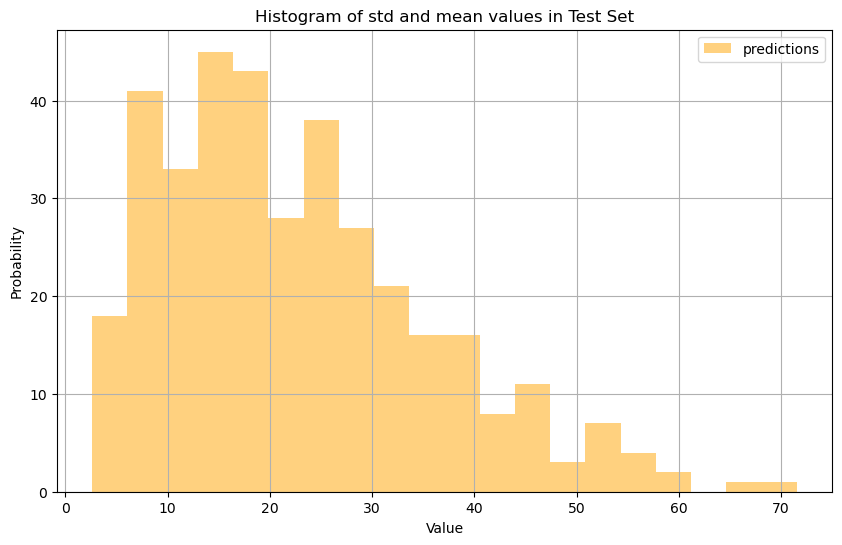

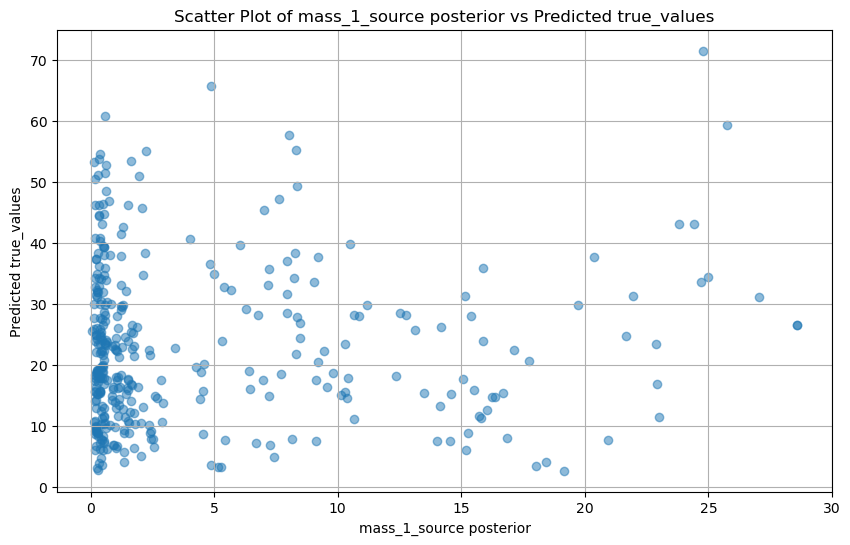

In [39]:
# Plot histogram of std and mean values (combined as features) in the test set
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=20, color='orange', alpha=0.5, label='predictions')
plt.title('Histogram of std and mean values in Test Set')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plot of X_test (std) vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:,0], y_pred, alpha=0.5)
plt.title('Scatter Plot of mass_1_source posterior vs Predicted true_values')
plt.xlabel('mass_1_source posterior')
plt.ylabel('Predicted true_values')
plt.grid(True)
plt.show()

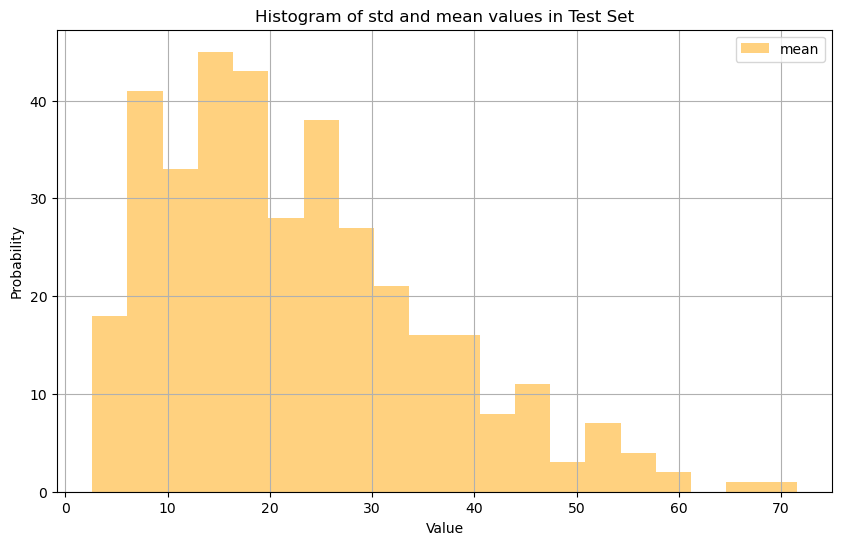

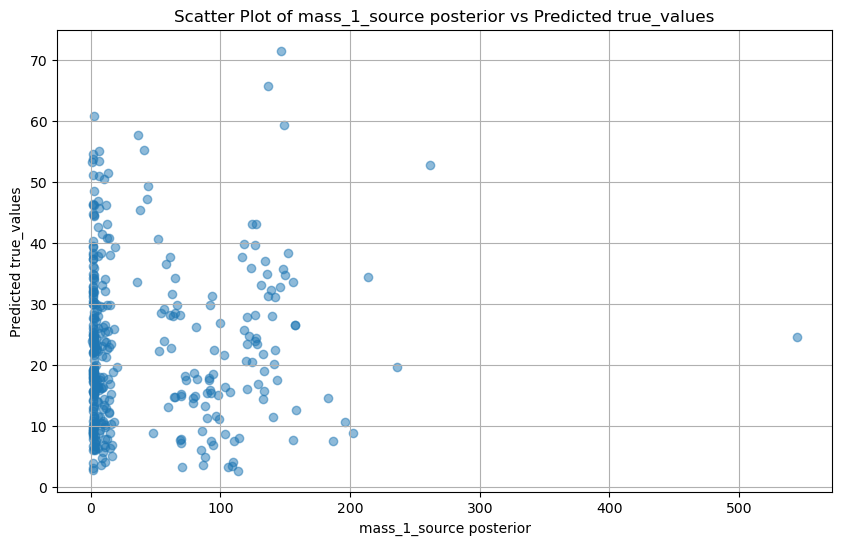

In [40]:
# Plot histogram of std and mean values (combined as features) in the test set
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=20, color='orange', alpha=0.5, label='mean')
plt.title('Histogram of std and mean values in Test Set')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter plot of X_test (mean) vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:,1], y_pred, alpha=0.5)
plt.title('Scatter Plot of mass_1_source posterior vs Predicted true_values')
plt.xlabel('mass_1_source posterior')
plt.ylabel('Predicted true_values')
plt.grid(True)
plt.show()

In [41]:
np.shape(X_test)

(363, 2)

In [42]:
X_test[:, 0]
#std

array([ 0.26229754, 18.02526309,  1.01643911,  0.59950708, 14.03523409,
        4.52941393, 10.64583393,  0.67075625,  0.28661899,  7.68839684,
        0.50636084,  7.20208042,  0.57040039,  0.38962647,  1.07499196,
        9.4374867 , 12.37424977, 11.20362069, 15.71870001,  0.45429263,
        1.2115794 ,  0.20173465,  2.10034567,  0.52484255,  0.29410107,
        0.24063971,  0.60323391,  0.6248481 , 15.51349103, 24.42400946,
       14.14930573,  0.51678179, 23.01632248,  5.31232516,  0.44861088,
        0.56143135,  0.16807999,  0.49608009,  0.58818107,  0.51472522,
        1.22191628,  1.1250505 ,  0.94605334,  0.28739211,  6.9955902 ,
        0.98194006,  0.56060715,  0.14395409,  0.36993495,  0.77605407,
        0.20502794,  9.57249033,  1.37438878, 10.37639866,  1.71904918,
        0.47397929,  0.42615188,  1.00854445,  0.28059468,  0.22557542,
        1.1312654 ,  7.01300851, 28.57629675,  0.33203885, 12.77564249,
        0.99185479,  0.74097017, 19.13901964,  1.61814874,  0.34

In [43]:
X_test[:,1]
#mean

array([  1.79707549, 109.10692699,   4.32564664,  12.72374978,
       110.57432469, 103.31920996,  98.99981413,   2.91626193,
         1.87867833,  94.51163254,   2.0579392 ,  69.46139359,
         2.44578112,   1.81405111,   3.51450718,  52.88464333,
        73.02313838,  66.88428678,  96.39887164,   2.44382235,
         7.11120149,   1.65210975,   6.56570958,   4.12627324,
         2.06726534,   1.81084436,   2.44040068,   2.68492182,
        91.69396605, 124.00247591,  88.03333828,   3.41262024,
       140.63762064,  56.22637265,   4.19060101,   2.06407345,
        10.18511723,   2.19911618,   2.9359749 , 235.98921162,
         3.6127186 ,   5.73820158,  16.47697606,   1.6753348 ,
        90.93294545,   4.57984768,   2.6924316 ,   1.29118062,
         1.91420134,   3.29491007,   1.78109923, 103.23350699,
         7.4044532 , 183.19914942,   7.2978576 ,   2.62976278,
         2.35954432,   4.91675779,   2.096179  ,   1.73249461,
         9.90480263,  38.11841043, 157.8457727 ,   2.20

In [44]:
y_pred

array([31.11590432,  3.40089004, 22.39610689, 29.75632567,  7.54162178,
        8.69132105, 11.1108793 ,  6.14392521,  8.86020658, 18.4379506 ,
       32.00642936, 14.80393638, 60.77079565, 29.97445084,  6.70211583,
       22.22503046, 18.20392568, 29.82814209, 11.59061322, 17.82882945,
       29.62935873, 12.8354825 , 45.66646278,  7.53324799, 17.18021549,
        8.82048703, 35.84331838, 33.94574698, 15.78304878, 43.09087664,
       13.20269241,  6.00068843, 11.4863984 , 23.84247601,  7.6142134 ,
       38.05383363, 50.45930002, 18.8519519 , 10.46776004, 19.6778752 ,
       18.30762179, 11.53340273,  6.77279368, 17.77733547, 17.4504492 ,
       23.26941171, 10.20321178, 53.2483834 , 23.41291496, 10.12164323,
       24.910533  , 16.34681847, 11.38752514, 14.57317733, 25.2497495 ,
       19.71863261, 10.25430918, 22.55846556, 18.56483328, 22.15574979,
       14.37047574, 45.31506073, 26.50643623, 44.40506992, 28.09215284,
        9.72900852, 46.81788105,  2.63673773, 14.07327082, 32.90

In [45]:
np.shape(y_pred)

(363,)

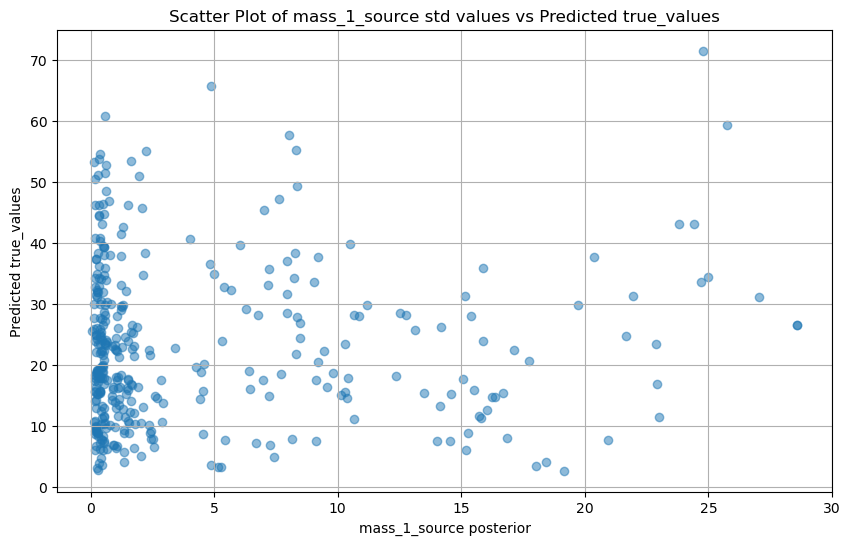

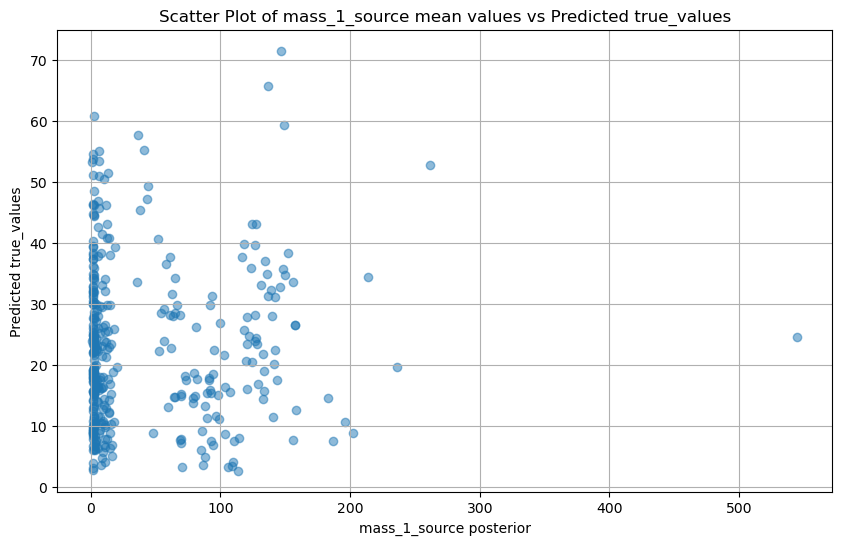

In [46]:
# Plot scatter plot of X_test (std) vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:,0], y_pred, alpha=0.5)
plt.title('Scatter Plot of mass_1_source std values vs Predicted true_values')
plt.xlabel('mass_1_source posterior')
plt.ylabel('Predicted true_values')
plt.grid(True)
plt.show()

# Plot scatter plot of X_test (mean) vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:,1], y_pred, alpha=0.5)
plt.title('Scatter Plot of mass_1_source mean values vs Predicted true_values')
plt.xlabel('mass_1_source posterior')
plt.ylabel('Predicted true_values')
plt.grid(True)
plt.show()

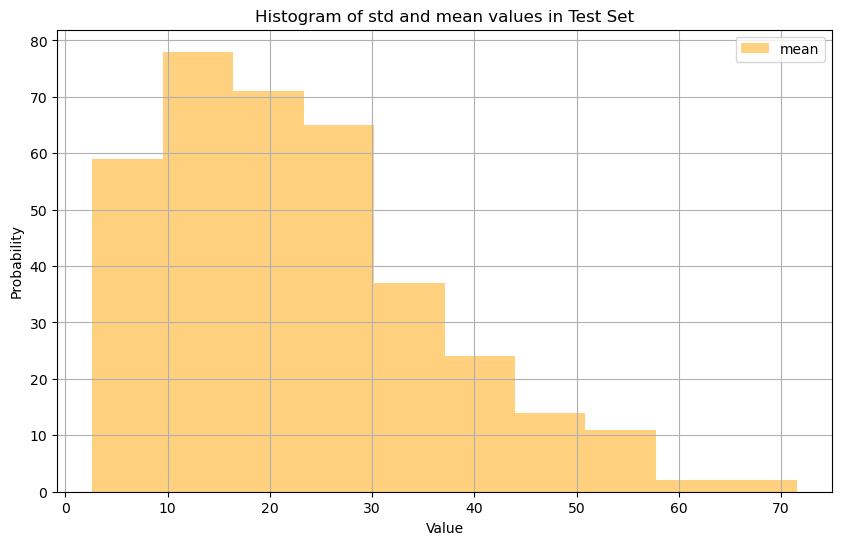

In [47]:
# Plot histogram of std and mean values (combined as features) in the test set
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=10, color='orange', alpha=0.5, label='mean')
plt.title('Histogram of std and mean values in Test Set')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
y_values[1]

1.6439075356977613

In [53]:
len(y_values)

1397

In [61]:
mass_1_source_array[2]

array([ 7.95625355,  9.3041081 , 10.43407493, ...,  8.90290014,
       12.16581542,  9.12907686])